In [48]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision.utils import save_image

from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [49]:
# pip install albumentations

In [50]:
# set parameters
DEVICE = 'cuda'
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 50
SAVE_PER_EPOCHS = 1
SAVE_MODEL = True
LOAD_MODEL = False
CHECKPOINT_DISC = 'disc.pth.tar'
CHECKPOINT_GEN = 'gen.pth.tar'

In [51]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE),y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * .5 + .5 # remove normalization
        save_image(y_fake, folder + f'/y_gen_{epoch}.png')
        if epoch == 0:
            # only the first epoch will save label and input sketch
            save_image(y * .5 + .5, folder+ f'/label_{epoch}.png')
            save_image(x * .5 + .5, folder + f'/input_{epoch}.png')
    gen.train()

def save_checkpoint(model, optimizer, filename='my_checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    checkpoint = {
        'state_dict':model.state_dict(),
        'optimizer':optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print('=> Loading checkpoint')
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    # load saved checkpoint
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [52]:
# CNN block will be used repeatly later
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.conv(x)

In [53]:
# x, y <- concatenate the gen image and the input image to determin the gen image is real or not
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0],kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(.2)
        )
        
        # save layers into a list
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
            
        # append last conv layer
        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')
        )
        
        # create a model using the list of layers
        self.model = nn.Sequential(*layers)
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

In [54]:
# block will be use repeatly later
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            # the block will be use on both encoder (down=True) and decoder (down=False)
            nn.Conv2d(in_channels, out_channels, 4,2,1,bias=False, padding_mode='reflect')
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4,2,1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == 'relu' else nn.LeakyReLU(.2)
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(.5)
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [55]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        # Encoder
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4,2,1, padding_mode='reflect'),
            nn.LeakyReLU(.2),
        )
        self.down1 = Block(features, features*2, down=True,act='leaky',use_dropout=False) #64
        self.down2 = Block(features*2, features*4, down=True,act='leaky',use_dropout=False) #32
        self.down3 = Block(features*4, features*8, down=True,act='leaky',use_dropout=False) #16
        self.down4 = Block(features*8, features*8, down=True,act='leaky',use_dropout=False) #8
        self.down5 = Block(features*8, features*8, down=True,act='leaky',use_dropout=False) #4
        self.down6 = Block(features*8, features*8, down=True,act='leaky',use_dropout=False) #2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4,2,1,padding_mode='reflect'),
            nn.ReLU(), # 1x1
        )
        # Decoder
        self.up1 = Block(features*8, features*8, down=False,act='relu',use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False,act='relu',use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False,act='relu',use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False,act='relu',use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False,act='relu',use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False,act='relu',use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False,act='relu',use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        # Encoder
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        
        # Decoder
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1,d7],1))
        u3 = self.up3(torch.cat([u2,d6],1))
        u4 = self.up4(torch.cat([u3,d5],1))
        u5 = self.up5(torch.cat([u4,d4],1))
        u6 = self.up6(torch.cat([u5,d3],1))
        u7 = self.up7(torch.cat([u6,d2],1))
        return self.final_up(torch.cat([u7, d1],1))

In [56]:
# Data Augmentation
class Transforms():
    def __init__(self):
        # use on both sketchs and colored images
        self.both_transform = A.Compose([
            A.Resize(width=256, height=256),
            A.HorizontalFlip(p=.5)
        ],additional_targets={'image0':'image'})
        
        # use on sketchs only
        self.transform_only_input = A.Compose([
            A.ColorJitter(p=.1),
            A.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5], max_pixel_value=255.0),
            ToTensorV2(),
        ])
        
        # use on colored images
        self.transform_only_mask = A.Compose([
            A.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5], max_pixel_value=255.0),
            ToTensorV2(),
        ])

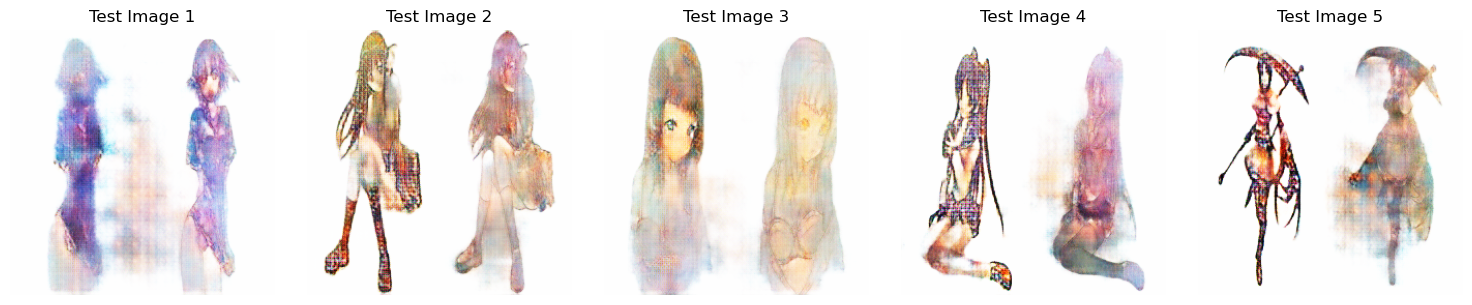

In [57]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# 加载生成器模型
gen = Generator(in_channels=3)
checkpoint_gen = torch.load('test2_model/gen.pth.tar')
gen.load_state_dict(checkpoint_gen['state_dict'])
gen.eval()

# 加载判别器模型
disc = Discriminator(in_channels=3)
checkpoint_disc = torch.load('test2_model/disc.pth.tar')
disc.load_state_dict(checkpoint_disc['state_dict'])
disc.eval()

# 图像预处理和后处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# 测试图像路径
test_images_dir = 'data/test/'

# 生成并显示测试图像
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, image_file in enumerate(os.listdir(test_images_dir)[:5]):
    image_path = os.path.join(test_images_dir, image_file)
    test_image = Image.open(image_path)
    test_image = transform(test_image).unsqueeze(0)

    with torch.no_grad():
        generated_image = gen(test_image)

    # 将生成的图像转换为 NumPy 数组，并取消标准化
    generated_image = generated_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    generated_image = (generated_image + 1) / 2  # 取消标准化

    axs[i].imshow(generated_image)
    axs[i].axis('off')
    axs[i].set_title(f'Test Image {i+1}')

plt.tight_layout()
plt.show()